In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
#from keras.preprocessing import sequence, text
#from keras.layers import Input, Embedding
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression

from nltk import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, KFold
import matplotlib.pyplot as plt
import lightgbm as lgb


import datetime as dt
import pandas as pd
import numpy as np
import warnings
import string

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## import data

In [2]:
# import both the training dataset and the resource dataset

df = pd.read_csv("train.csv", parse_dates=["project_submitted_datetime"])
#df = pd.read_csv("test.csv", parse_dates=["project_submitted_datetime"])
rc = pd.read_csv("resources.csv").fillna('')

#df = pd.concat([train, test], axis=0) 

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## data cleaning

In [3]:
# stop words

stop_words = list(set(stopwords.words('english')))
warnings.filterwarnings('ignore')
punctuation = string.punctuation


# length fun

def length(text):
    try:
        return len(text)
    except:
        return 0

In [4]:
# aggregate numerical variables

rc['total_price'] = rc['quantity']*rc['price']
agg_rc = rc.groupby('id').agg({'description':'count', 'quantity':'sum', 'price':'sum', 'total_price':'sum'}).rename(columns={'description':'items'})

for func in ['min', 'max', 'mean']:
    agg_rc_temp = rc.groupby('id').agg({'quantity':func, 'price':func, 'total_price':func}).rename(columns={'quantity':func+'_quantity', 'price':func+'_price', 'total_price':func+'_total_price'}).fillna(0)
    agg_rc = agg_rc.join(agg_rc_temp)

agg_rc = agg_rc.join(rc.groupby('id').agg({'description':lambda x:' '.join(x.values.astype(str))}).rename(columns={'description':'resource_description'}))



In [5]:
# join the training dataset and the resource dataset

df = df.join(agg_rc, on='id')

In [7]:
# a quick look of the joined dataframe

df.describe()

,teacher_number_of_previously_posted_projects,items,quantity,price,total_price,min_quantity,min_price,min_total_price,max_quantity,max_price,max_total_price,mean_quantity,mean_price,mean_total_price
count,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000
mean,11.275082,5.887640,16.898340,298.460543,542.857826,4.116294,93.206521,199.768203,7.682437,179.870531,352.674682,5.254032,124.438603,257.219735
std,27.981717,8.267504,26.611139,373.466571,546.687189,11.840619,290.536650,418.905416,16.181940,319.290965,477.782337,12.338140,292.025871,423.189337
min,0.000000,1.000000,1.000000,0.900000,100.000000,1.000000,0.000000,0.000000,1.000000,0.900000,3.990000,1.000000,0.900000,2.431667
25%,0.000000,1.000000,4.000000,104.980000,245.990000,1.000000,6.690000,11.990000,1.000000,39.990000,104.950000,1.000000,20.071000,50.352500
50%,2.000000,3.000000,9.000000,206.200000,396.720000,1.000000,15.990000,45.000000,3.000000,99.500000,218.010000,2.000000,51.390000,127.808333
75%,9.000000,7.000000,21.000000,381.230000,688.110000,2.000000,74.990000,224.750000,6.000000,223.110000,416.430000,4.333333,143.990000,307.370000
max,448.000000,100.000000,879.000000,9999.000000,17901.940000,601.000000,9999.000000,9999.000000,601.000000,9999.000000,16055.940000,601.000000,9999.000000,9999.000000


In [8]:
# time variables 

df["Year"] = df["project_submitted_datetime"].dt.year
df["Month"] = df["project_submitted_datetime"].dt.month
df['Weekday'] = df['project_submitted_datetime'].dt.weekday
df["Hour"] = df["project_submitted_datetime"].dt.hour
df["Month_Day"] = df['project_submitted_datetime'].dt.day
df["Year_Day"] = df['project_submitted_datetime'].dt.dayofyear

In [9]:
# essay length

df['project_essay_3'] = df['project_essay_3'].fillna('')
df['project_essay_4'] = df['project_essay_4'].fillna('')

# extract length of each essay and title

df["essay1_len"] = df['project_essay_1'].apply(length)
df["essay2_len"] = df['project_essay_2'].apply(length)
df["essay3_len"] = df['project_essay_3'].apply(length)
df["essay4_len"] = df['project_essay_4'].apply(length)
df["title_len"] = df['project_title'].apply(length)

In [10]:
# word count

df['text'] = df.apply(lambda row: ' '.join([str(row['project_essay_1']), 
                                            str(row['project_essay_2']), 
                                            str(row['project_essay_3']), 
                                            str(row['project_essay_4'])]), axis=1)

# extract features from text

df['char_count'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1)
df['punctuation_count'] = df['text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 
df['title_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df['upper_case_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
df['stopword_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))

In [11]:
# functions to get polatiy and subjectivity of text using the module textblob

def get_polarity(text):
    try:
        textblob = TextBlob(text)
        pol = textblob.sentiment.polarity
    except:
        pol = 0
    return pol

def get_subjectivity(text):
    try:
        textblob = TextBlob(text)
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj



In [12]:
# extrac the polarity and subjectivity score of the essays and titles

df['polarity'] = df['text'].apply(get_polarity)
df['subjectivity'] = df['text'].apply(get_subjectivity)
df['title_polarity'] = df['project_title'].apply(get_polarity)
df['title_subjectivity'] = df['project_title'].apply(get_subjectivity)

In [13]:
# TF-IDF Features

df['article_text'] = df.apply(lambda row: ' '.join([str(row['project_essay_1']), str(row['project_essay_2']), 
                                         str(row['project_essay_3']), str(row['project_essay_4'])]), axis=1)
df['resource_text'] = df.apply(lambda row: ' '.join([str(row['resource_description']), str(row['project_resource_summary'])]), axis=1)


In [14]:
# word level tf-idf for article text

vect_word = TfidfVectorizer(max_features=10, analyzer='word', stop_words='english', ngram_range=(1,3), dtype=np.float32) 
vect_word.fit(df['article_text'])
tfidf_complete = vect_word.transform(df['article_text'])

df_tfidf_complete = pd.DataFrame(tfidf_complete.toarray(), columns=vect_word.get_feature_names())
df_tfidf_complete.columns = ['article_text_classroom', 'article_text_help', 'article_text_learn', 'article_text_learning', 
                             'article_text_need', 'article_text_reading', 'article_text_school',
                             'article_text_students', 'article_text_use', 'article_text_work']

In [18]:
# word level tf-idf for resource text

vect_word = TfidfVectorizer(max_features=10, analyzer='word', stop_words='english', ngram_range=(1,3), dtype=np.float32) 
vect_word.fit(df['article_text'])
tfidf_resource = vect_word.transform(df['article_text'])

df_tfidf_resource = pd.DataFrame(tfidf_resource.toarray(), columns=vect_word.get_feature_names())
df_tfidf_resource.columns = ['resource_text_classroom', 'resource_text_help', 'resource_text_learn', 'resource_text_learning', 
                             'resource_text_need', 'resource_text_reading', 'resource_text_school',
                             'resource_text_students', 'resource_text_use', 'resource_text_work']


In [20]:
# merge the tf-idf features to the main dataframe

df_tfidf = pd.concat([df_tfidf_complete, df_tfidf_resource], axis=1)
df = pd.concat([df,df_tfidf], axis=1)

In [24]:
# extract gender information from the prefix of applicant

gender = {'Mr.':'Male', 'Mrs.':'Female', 'Ms.':'Female', 'Teacher':'Unknown','Dr.':'Unknown'}
df['gender'] = df['teacher_prefix'].map(gender)


In [26]:
# get rid of the string variables

df = df.drop(['teacher_prefix','text','project_submitted_datetime','teacher_id','id',
              'project_essay_1','project_essay_2', 'project_essay_3','project_essay_4',
              'project_title','project_resource_summary','article_text', 'resource_text',
              'resource_description'],axis=1)

In [28]:
# split the project subcategory into different columns

df[['Project_SubCategory_1','Project_SubCategory_2','Project_SubCategory_3']] = 
df['project_subject_subcategories'].str.split(',', expand=True)

df = df.drop(['project_subject_subcategories'],axis = 1)

In [38]:
# transform all the columns to categorical data

df['school_state'] = df['school_state'].astype('category')
df['project_grade_category'] = df['project_grade_category'].astype('category')
df['project_subject_categories'] = df['project_subject_categories'].astype('category')
df['gender'] = df['gender'].astype('category')
df['Project_SubCategory_1'] = df['Project_SubCategory_1'].astype('category')
df['Project_SubCategory_2'] = df['Project_SubCategory_2'].astype('category')
df['Project_SubCategory_3'] = df['Project_SubCategory_3'].astype('category')


In [39]:
# transform categorical variables to labels 

df['school_state'] = df['school_state'].cat.codes
df['project_grade_category'] = df['project_grade_category'].cat.codes
df['project_subject_categories'] = df['project_subject_categories'].cat.codes
df['gender'] = df['gender'].cat.codes
df['Project_SubCategory_1'] = df['Project_SubCategory_1'].cat.codes
df['Project_SubCategory_2'] = df['Project_SubCategory_2'].cat.codes
df['Project_SubCategory_3'] = df['Project_SubCategory_3'].cat.codes

In [ ]:
# output the file

df.to_excel('train_final.xlsx',index=False)

## Feature selection

In [87]:
# identify dependent and independent variables 

X = df.drop(['project_is_approved'],axis = 1).iloc[:,:]
y = df.iloc[:,4]

In [137]:
# normalization and search for best lasso regularization 

scaler = StandardScaler()
scaler.fit
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42, stratify = y)

cv_outer = KFold(n_splits=3)
lasso = Lasso()
param_lasso = {'alpha':np.logspace(-6,-7,2)}

lasso_cv = GridSearchCV(lasso, param_grid=param_lasso, cv=3)
lasso_cv.fit(X_train, y_train)

scores = cross_val_score(lasso_cv, X, y, cv=cv_outer)

In [140]:
# best parameter for lasso

lasso_cv.best_estimator_

Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00  2.23250136e-02
 -1.07072948e-02 -7.24294525e-03 -6.18893326e-02 -1.87916409e-02
  4.60327425e-03 -1.86787284e-03 -6.29775952e-03 -2.21265619e-02
  1.83515361e-02  4.53571524e-04  2.65212016e-02  3.56277454e-02
  3.38213852e-02  7.20163613e-04  0.00000000e+00  1.01981793e-03
  8.27712854e-04  3.09675665e-03  2.51802665e-05 -1.82383237e-02
  8.76499843e-03  0.00000000e+00 -3.07870155e-03  9.86409726e-04
  0.00000000e+00  9.33425620e-02 -1.58695373e-02 -0.00000000e+00
  5.44639334e-03 -1.60515568e-02 -6.11626769e-02 -0.00000000e+00
  3.93562517e-03 -8.40017414e-05 -1.24990005e-03  6.90109164e-03
  0.00000000e+00 -6.44276237e-04 -4.21469084e-04  8.91950737e-04
  2.21038720e-02  1.11729300e-05  1.11000923e-02  1.44240632e-02
  1.52548707e-03  4.37618771e-03  6.86889222e-04 -2.04773095e-04
 -2.39881610e-04  3.00204238e-03  5.36296098e-03  1.68782130e-03
  5.07004430e-03  1.55238154e-03  7.32864656e-04 -5.49537389e-03
  6.35462569e-03 -1.54877

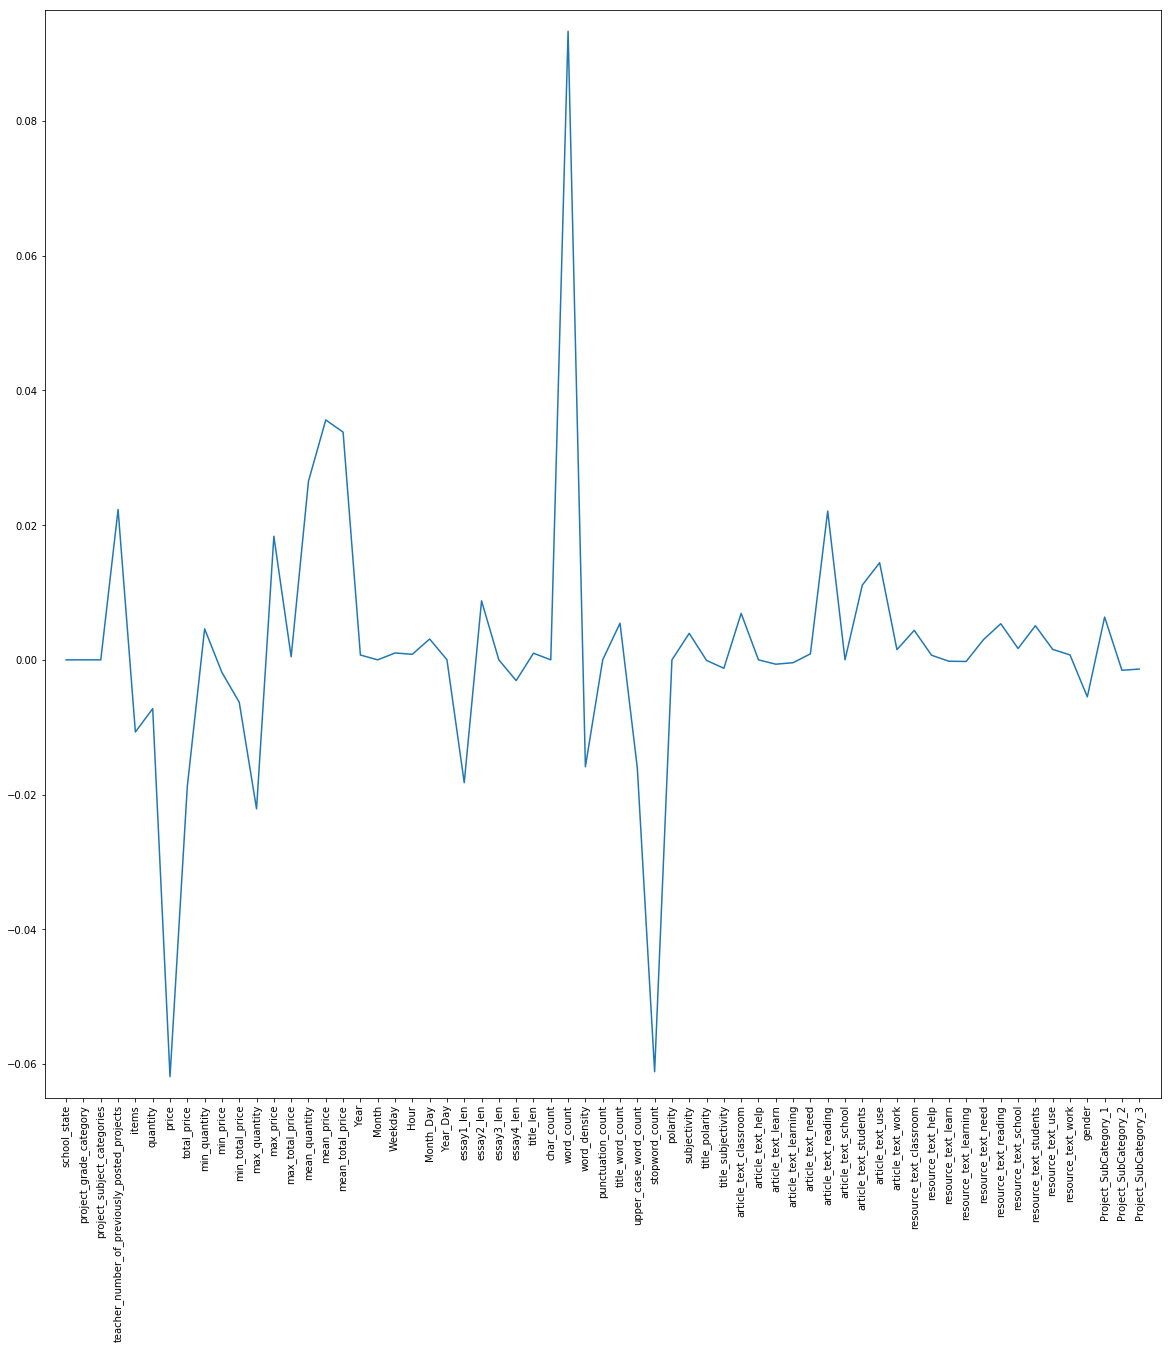

In [141]:
# lasso regularization and feature selection

scaler = StandardScaler()
scaler.fit
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42, stratify = y)

lasso = Lasso(alpha = 1e-6, normalize=True)


lasso.fit(X,y)

lasso_coef = lasso.fit(X,y).coef_
print(lasso_coef)

# Plot the coefficients
plt.figure(figsize = (20,20))
plt.plot(range(63), lasso_coef)
#plt.xticks(range(len(X.columns)), X.columns.values, rotation=60)
plt.margins(0.02)
#plt.figure(figsize = (20,20))
plt.xticks(range(63),('school_state', 'project_grade_category', 'project_subject_categories',
       'teacher_number_of_previously_posted_projects',
       'items', 'quantity', 'price', 'total_price', 'min_quantity',
       'min_price', 'min_total_price', 'max_quantity', 'max_price',
       'max_total_price', 'mean_quantity', 'mean_price', 'mean_total_price',
       'Year', 'Month', 'Weekday', 'Hour', 'Month_Day', 'Year_Day',
       'essay1_len', 'essay2_len', 'essay3_len', 'essay4_len', 'title_len',
       'char_count', 'word_count', 'word_density', 'punctuation_count',
       'title_word_count', 'upper_case_word_count', 'stopword_count',
       'polarity', 'subjectivity', 'title_polarity', 'title_subjectivity',
       'article_text_classroom', 'article_text_help', 'article_text_learn',
       'article_text_learning', 'article_text_need', 'article_text_reading',
       'article_text_school', 'article_text_students', 'article_text_use',
       'article_text_work', 'resource_text_classroom', 'resource_text_help',
       'resource_text_learn', 'resource_text_learning', 'resource_text_need',
       'resource_text_reading', 'resource_text_school',
       'resource_text_students', 'resource_text_use', 'resource_text_work',
       'gender', 'Project_SubCategory_1', 'Project_SubCategory_2',
       'Project_SubCategory_3'), rotation=90)
plt.show()
